# SNN to detect HFOs in iEEG data

In [1]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation

# Adjust the Working Directory

In [2]:
# Print current Working Directory
print(os.getcwd())

# Check if the current WD is the file location
if "lava-dl/src/hfo" not in os.getcwd():
    # Set working directory to this file location
    file_location = f"{os.getcwd()}/lava-dl/src/hfo/"
    print("File Location: ", file_location)

    # Change the current working Directory
    os.chdir(file_location)

    # New Working Directory
    print("New Working Directory: ", os.getcwd())

/home/monkin/Desktop/feup/thesis
File Location:  /home/monkin/Desktop/feup/thesis/lava-dl/src/hfo/
New Working Directory:  /home/monkin/Desktop/feup/thesis/lava-dl/src/hfo


# Check if GPU is Available

In [3]:
# Check if GPU is available
print(torch.cuda.is_available())

print(torch.cuda.device_count())

True
1


# Create Network

A slayer network definition follows standard PyTorch way using `torch.nn.Module`.

The network can be described with a combination of individual `synapse`, `dendrite`, `neuron` and `axon` components. For rapid and easy development, slayer provides __block interface__ - `slayer.block` - which bundles all these individual components into a single unit. These blocks can be cascaded to build a network easily. The block interface provides additional utilities for normalization (weight and neuron), dropout, gradient monitoring and network export.

In the example below, `slayer.block.cuba` is illustrated.

In [4]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # TODO: Change the parameters of the neuron
        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
        }
        # Add dropout to the network
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                # Input of 2 neurons (spike train UP and DOWN) and output of 512 neurons
                slayer.block.cuba.Dense(neuron_params_drop, 2, 256, weight_norm=True, delay=True),
                
                # Final Layer with 2 neurons that spike if a Ripple or Fast Ripple are detected respectively
                slayer.block.cuba.Dense(neuron_params, 512, 2, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

# Instantiate Network, Optimizer, DataSet and DataLoader

Running the network in GPU is as simple as selecting `torch.device('cuda')`.

In [6]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cpu')
# device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## Prepare the Dataset and DataLoader

### Import the Dataset to a numpy array

Since the `lava-dl` package has a symbolic link to the `lava` package, we can use the `utils` module from the `lava` package directly

In [7]:
from utils.io import preview_np_array

input_filename = 'snn_input_ripple_5_-5.npy'
input_spikes = np.load(f"data/{input_filename}")

preview_np_array(input_spikes, "Input Spikes")

Input Spikes Shape: (245760, 2).
Preview: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


### Define the `Datasets` and `DataLoaders`

`PyTorch` provides 2 data primitives - `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` to work with data.
- `Dataset` stores the samples and their corresponding labels.
- `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

In [8]:
from torch.utils.data import DataLoader
from data.ripple_spike_trains_dataset import SpikeTrainsDataset

# Load the Dataset by providing the filename
input_filename = 'data/snn_input_ripple_5_-5.npy'
annotations_filename = 'data/snn_annotations_ripple_5_-5.npy'
snn_dataset = SpikeTrainsDataset(input_filename, annotations_filename, verbose=True)

Input Spikes Shape: (245760, 2).
Preview: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


### Split the data into training, validation and test sets

Need to evaluate the need for a validation set. For now, we will use a 70/10/20 split for training, validation and test sets respectively.

The **spike trains data is ordered**, so we **cannot shuffle** the data as it would disrupt the temporal sequence of the data.

In [9]:
from sklearn.model_selection import train_test_split

# Split the dataset into Training and Validation+Testing tests
# 70% Training, 30% Validation+Testing
# Since we are working with temporal data, we will split the dataset in order (NO SHUFFLE)
train_dataset, val_test_dataset = train_test_split(snn_dataset, test_size=0.3, shuffle=False)

# Split the Validation+Testing dataset into Validation and Testing sets
# 10% Validation, 20% Testing
val_dataset, test_dataset = train_test_split(val_test_dataset, test_size=0.67, shuffle=False)

### Create the `DataLoader` objects
The `batch_size` parameter determines the number of samples that will be loaded and passed through the network at once during training. It's a form of stochastic gradient where instead of updating the weights after each sample, you can update the weights based on a subset of data (a batch).

When working with temporal sequential data, the order is very important. However, the `batch_size` does not directly affect the order of the data. In fact, when working with time series data, it might be relevant to use sequences/windows of data as input for the model. For example, if we want to predict the next value of a sequence, we can use a window of `n` samples as input. In this case, each "sample" in your batch would actually be a sequence of `n` values.

Once again, shuffle is set to `False` to maintain the temporal sequence of the data.

### **Batch Size**
The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. In our case, it makes sense to use a batch size equal to the ***prediction window*** size. This way, we can identify the presence of Ripple or Fast Ripples using the entire window of data.

In [10]:
# Define the batch_size / window_size
window_size = 100

In [11]:
# Create the DataLoader for the Training, Validation and Testing Datasets
train_loader = DataLoader(train_dataset, batch_size=window_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=window_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=window_size, shuffle=False)

# Visualize the input data

A `slayer.io.Event` can be visualized by invoking it's `Event.show()` routine. `Event.anim()` instead returns the event visualization animation which can be embedded in notebook or exported as video/gif. Here, we will export gif animation and visualize it.

To visualize the input data as a gif, we need to convert each time step into an image. We can use the `Event.show()` method to do this. The `Event.show()` method returns a `matplotlib` figure which can be saved as an image. We can then use the `imageio` package to convert the images into a gif.

In [26]:
# Convert each time step into an image
img_height = 25
img_width = 25

spike_width = 3     # Width of the spike
spike_interval = 2  # Space between spikes
spike_positions = [0, 5, 10, 15, 20]    # Positions of the spikes based on spike_width and spike_interval

y_padding = 5
up_spike_y = img_height - y_padding
down_spike_y = y_padding

def color_pixels(batch, img, idx, x_position_idx):
    # Check if batch[idx] had an UP spike
    if batch[idx][0] == 1:
        # Color the pixels where the spike is detected
        img[spike_positions[x_position_idx]:spike_positions[x_position_idx]+spike_width][up_spike_y] = 1
    
    # Check if batch[idx] had a DOWN spike
    if batch[idx][1] == 1:
        # Color the pixels where the spike is detected
        img[spike_positions[x_position_idx]:spike_positions[x_position_idx]+spike_width][down_spike_y] = 1

def batch_to_image_array(batch):
    """
    Convert a batch of spikes into an array of images that can be visualized using slayer
    """
    # Create new batch object with the shape (num_channels, img_height, img_width, window_size)
    # num_channels is 1
    new_batch = np.ndarray(shape=(1, img_height, img_width, len(batch)))

    for idx in range(len(batch)):
        # Initialize the image as a 2D array of zeros
        img = np.zeros(shape=(img_height, img_width))

        # Color the middle line to represent the current time step (Width 1)
        img[:, img_width//2] = 1

        # --- Color the pixels where a spike is detected as 1 --- # 
        if idx >= 2:
            # Color the pixels of the t-2 time step
            color_pixels(batch, img, idx-2, 0)
        if idx >= 1:
            # Color the pixels of the t-1 time step
            color_pixels(batch, img, idx-1, 1)
        # Color the pixels of the current time step

        color_pixels(batch, img, idx, 2)
        if idx+1 < len(batch):
            # Color the pixels of the t+1 time step
            color_pixels(batch, img, idx+1, 3)
        if idx+2 < len(batch):
            # Color the pixels of the t+2 time step
            color_pixels(batch, img, idx+2, 4)
        
        # Update the new_batch with the current batch corresponding image
        new_batch[0, :, :, idx] = img

    return new_batch

In [32]:
# Iterate 80 times before getting the next batch
for i in range(84):
    next(iter(train_loader))
train_features, train_label = next(iter(train_loader))

new_batch = batch_to_image_array(train_features)
preview_np_array(new_batch, "Image Array")

Image Array Shape: (1, 25, 25, 100).
Preview: [[[[0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   ...
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   ...
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]


In [60]:


for i in range(10):
    # Fetch a random input and target from the training dataset
    train_features, train_label = next(iter(train_loader))

    print("\nIdx:", i)
    # preview_np_array(train_features, "Train Features")
    # preview_np_array(train_label, "Train Labels")
    
    # Transpose the input spikes to get (channels, num_inputs)
    # The resulting nparray will store the input spikes in the following format:
    # [
    #  [input_UP_1, input_UP_2, ..., input_UP_N],
    #  [input_DOWN_1, input_DOWN_2, ..., input_DOWN_N]
    # ]
    # train_features_T = train_features.T
    # print("Train Features Transposed Shape: ", train_features_T.shape)
    

    anim = slayer_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    anim.save(f'data/gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)


    
    # spike_tensor = train_features.reshape(100, 2, 1)

    # reshape the 2D tensor to the shape (sign_event, height_img, width_img, num_time_bins) to separate the events of each timestamp
    # spike_tensor = spike_tensor.reshape(2, 34, 34, -1)  
    
    # event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())
    # anim = event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    # anim.save(f'gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)


Idx: 0

Idx: 1

Idx: 2

Idx: 3


/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))
/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))
/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))
/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_


Idx: 4

Idx: 5

Idx: 6

Idx: 7


/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))
/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))
/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))
/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_


Idx: 8

Idx: 9


/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))
/home/monkin/Desktop/feup/thesis/lava-dl/src/lava/lib/dl/slayer/io.py:275: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis((t_min - 0.1 * t_max, 1.1 * t_max, -0.1 * x_dim, 1.1 * x_dim))


In [ ]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'
header = '<table><tr>'
images = ' '.join([gif_td(f'gifs/input{i}.gif') for i in range(5)])
footer = '</tr></table>'
display.HTML(header + images + footer)

,,,,


# Error module

Slayer provides prebuilt loss modules: `slayer.loss.{SpikeTime, SpikeRate, SpikeMax}`.
* `SpikeTime`: precise spike time based loss when target spike train is known.
* `SpikeRate`: spike rate based loss when desired rate of the output neuron is known.
* `SpikeMax`: negative log likelihood losses for classification without any rate tuning.

Since the target spike train is not known for this problem, we use `SpikeRate` loss and target high spiking rate for true class and low spiking rate for false class.

target rate: $\hat{\boldsymbol r} = r_\text{true}\,{\bf 1}[\text{label}] + r_\text{false}\,(1-{\bf 1}[\text{label}])$ where ${\bf 1}[\text{label}]$ is one-hot encoding of label. The loss is:

$$L = \frac{1}{2} \left(\frac{1}{T}\int_T {\boldsymbol s}(t)\,\text dt -  \hat{\boldsymbol r}\right)^\top {\bf 1}$$

In [ ]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)

# Stats and Assistants

Slayer provides `slayer.utils.LearningStats` as a simple learning statistics logger for training, validation and testing.

In addtion, `slayer.utils.Assistant` module wraps common training validation and testing routine which help simplify the training routine.

In [ ]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

# Training Loop

Training loop mainly consists of looping over epochs and calling `assistant.train` and `assistant.test` utilities over training and testing dataset. The `assistant` utility takes care of statndard backpropagation procedure internally.

* `stats` can be used in print statement to get formatted stats printout.
* `stats.testing.best_accuracy` can be used to find out if the current iteration has the best testing accuracy. Here, we use it to save the best model.
* `stats.update()` updates the stats collected for the epoch.
* `stats.save` saves the stats in files.

In [ ]:
# epochs = 100
epochs = 1

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
        print(f"Training epoch {i}/{len(train_loader)}", end="\r")
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    for i, (input, label) in enumerate(test_loader): # training loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

KeyboardInterrupt: 

# Plot the learning curves

Plotting the learning curves is as easy as calling `stats.plot()`.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


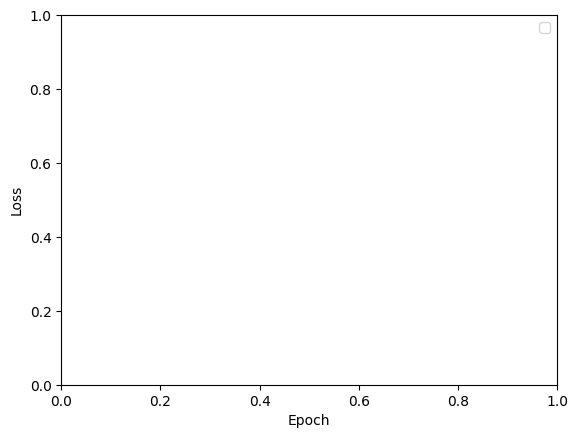

In [ ]:
stats.plot(figsize=(15, 5))

# Export the best model

Load the best model during training and export it as hdf5 network. It is supported by `lava.lib.dl.netx` to automatically load the network as a lava process.

In [ ]:
if torch.cuda.is_available():
    net.load_state_dict(torch.load(trained_folder + '/network.pt'))
else:
    net.load_state_dict(torch.load(trained_folder + '/network.pt', map_location=torch.device('cpu')))


net.export_hdf5(trained_folder + '/network.net')

# Visualize the network output

Here, we will use `slayer.io.tensor_to_event` method to convert the torch output spike tensor into `slayer.io.Event` object and visualize a few input and output event pairs.

In [ ]:
output = net(input.to(device))
for i in range(5):
    # Reshape the input to the shape (sign_event, height_img, width_img, num_time_bins) to separate each DVS event
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(2, 34, 34, -1))

    # Reshape the output to a list containing the prediction percentage of each class
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))

    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=240)
    inp_anim.save(f'gifs/inp{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)


In [ ]:
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'gifs/inp{i}.gif')
    html += gif_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

Input,Output
,
,
,
,
,
